In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
#for importing data
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader,Subset
from torchvision import datasets, transforms

In [ ]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#transformations
transform = T.Compose([T.ToTensor(),
                      T.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224,0.225])
                      ])
#normalizes to range [0,1]

In [ ]:
#import the data and simultaneosly apply the transform
trainset = torchvision.datasets.STL10(root= './data', download = True, split='train', transform=transform)
testset = torchvision.datasets.STL10(root='./data', download=True, split = 'test',transform = transform)

100%|██████████| 2640397119/2640397119 [03:01<00:00, 14532453.71it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
#transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size = batchsize, shuffle=True, drop_last= True)
test_loader = DataLoader(testset, batch_size=256)

In [ ]:
#check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape)
print( testset.data.shape)

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)


In [ ]:
#chechkout the range of pixel intensity values
print('\nData value range:')
print((np.min(trainset.data), np.max(trainset.data)))


Data value range:
(0, 255)


In [ ]:
# the unique characters
print('Data categories:')
print( trainset.classes )

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [ ]:
# the images are of wrong dimension
# they need to be 3x96x96
# and they are not normalised as well

X,y = next(iter(train_loader))
#here we're pulling data out of the data loader and the normalisation gets applied

print(X.data.shape)

print('\n data value range:')
print(( torch.min(X.data), torch.max(X.data)))




torch.Size([32, 3, 96, 96])

 data value range:
(tensor(-2.1179), tensor(2.6400))


(array([15594., 16540.,  2441.,  3526.,  2692.,  5006., 22274.,  8027.,
         8485.,  9019., 10454.,  8021., 10881., 10297.,  9365.,  9397.,
        10551., 10553.,  7230., 10866., 10956., 11342.,  7701., 11649.,
        11869.,  8961., 11542., 10340., 12090.,  9891., 12877., 11460.,
        12318., 12423., 14075., 14493., 10706., 12089., 13818., 13739.,
         8869., 13106., 13221., 11051., 10901., 11046., 11759., 10419.,
        10085., 10797., 10013.,  9569., 10781., 10770.,  8507., 10253.,
        11058.,  9638.,  9294., 10245., 11550., 10469., 10277.,  9099.,
         9216., 10036.,  8828.,  8446.,  8436.,  9471.,  8432.,  7916.,
         7694.,  8610.,  7715.,  6983.,  6884.,  6728.,  7714.,  5064.,
         6064.,  6246.,  4823.,  5267.,  5519.,  4496.,  4763.,  5983.,
         4837.,  4211.,  4735.,  6050.,  2523.,  2302.,  2103.,  2571.,
          807.,  1273.,  2059.,  1596.]),
 array([-2.11790395, -2.0703249 , -2.02274585, -1.9751668 , -1.92758775,
        -1.8800087 , 

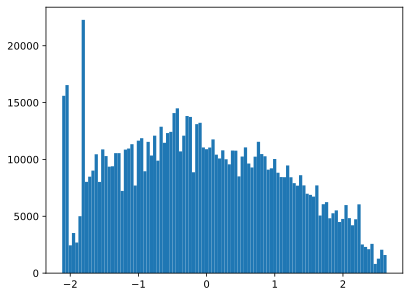

In [ ]:
#histogram of the data
plt.hist(X.data.numpy().flatten(),100)

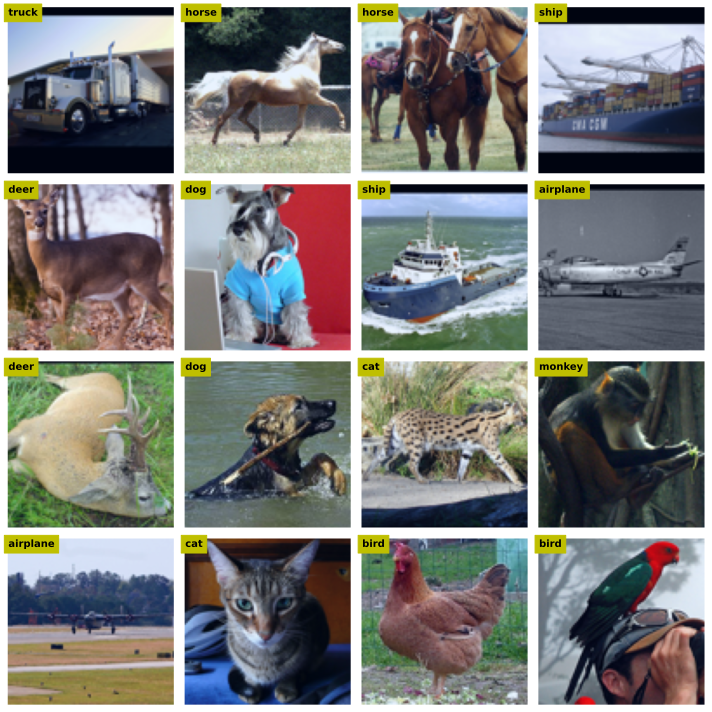

In [ ]:
#inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):


  #extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) #undo normalisation
  pic = pic/np.max(pic)

  # and it's labels
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top', fontweight = 'bold', color='k', backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

Import and inspect renet models

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
from torchsummary import summary
summary(resnet.to(device), (3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [ ]:
#freeze all layers (final layer changed later )
for p in resnet.parameters():
  p.requires_grad = False

  #python note: the above operation can be implemented in-line
  #p.requires_grad_(False)



In [ ]:
#change the final layer
resnet.fc = nn.Linear(512,10)

In [ ]:
#push the model to the GPU (if using)
resnet.to(device);


# Train the model

In [ ]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum= .9)

In [ ]:
numepochs = 10

# initialise losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

#loop over epochs
for epochi in range(numepochs):

  #loop over training data batches
  resnet.train() #switch to train mode
  batchLoss = []
  batchAcc = []
  for X,y in train_loader:

    #push data to GPU
    X = X.to(device)
    y = y.to(device)

    #forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat, y)

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    #end of batch loop

#and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi] = 100*np.mean(batchAcc)


#print out a status update
print(f'Finished epoch {epochi + 1}/{numepochs}. Train accuracy = {trainAcc[epochi]:.2f}% Train Loss = {trainLoss[epochi]:.2f}%')

Finished epoch 10/10. Train accuracy = 83.59% Train Loss = 0.49%


In [ ]:
for epochi in range(numepochs):

  #loop over training data batches
  resnet.eval() #switch to train mode
  batchLoss = []
  batchAcc = []
  for X,y in test_loader:

    #push data to GPU
    X = X.to(device)
    y = y.to(device)

    #forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat, y)

    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    #end of batch loop

  #and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi] = 100*np.mean(batchAcc)


#print out a status update
print(f'Finished epoch {epochi + 1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}% Train Loss = {testLoss[epochi]:.2f}%')

Finished epoch 10/10. Test accuracy = 78.77% Train Loss = 0.63%


Visualize the performance

In [ ]:
print(trainLoss)
print(testLoss)

print(trainAcc)
print(testAcc)

tensor([0.4987, 0.5039, 0.5032, 0.5005, 0.5074, 0.5036, 0.4970, 0.4966, 0.4960,
        0.4943])
tensor([0.6252, 0.6252, 0.6252, 0.6252, 0.6252, 0.6252, 0.6252, 0.6252, 0.6252,
        0.6252])
tensor([83.0729, 83.0929, 82.6723, 82.6923, 82.7524, 83.3333, 83.9143, 83.5537,
        83.1731, 83.5938])
tensor([78.7720, 78.7720, 78.7720, 78.7720, 78.7720, 78.7720, 78.7720, 78.7720,
        78.7720, 78.7720])


not correct
comparison visualisation

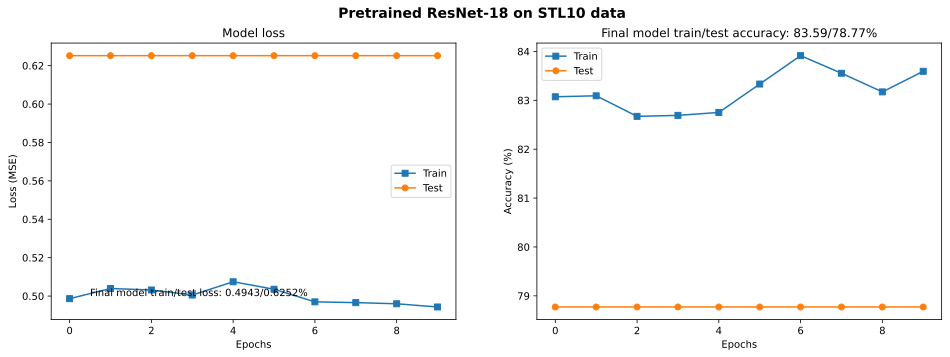

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].text(0.5, 0.5, f'Final model train/test loss: {trainLoss[-1]:.4f}/{testLoss[-1]:.4f}%')
ax[0].legend()

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(testAcc, 'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')  # Corrected line
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data', fontweight='bold', fontsize=14)  # Corrected line
plt.show()


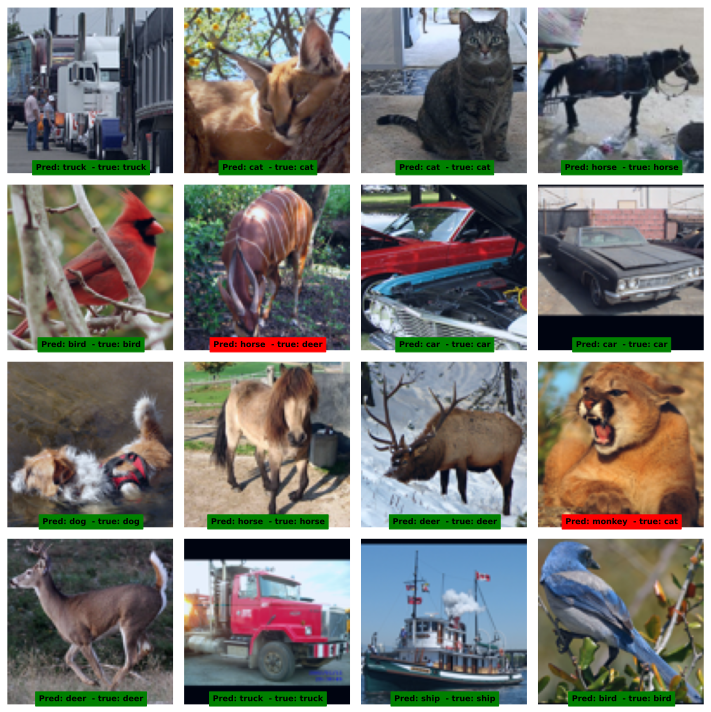

In [ ]:
predictions = torch.argmax(resnet(X), axis=1)

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1, 2, 0))  # Corrected spelling
    pic = pic - np.min(pic)  # undo normalization
    pic = pic / np.max(pic)

    # show the image
    ax.imshow(pic)

    # label and true class
    label = trainset.classes[predictions[i]]
    truec = trainset.classes[y[i]]
    title = f'Pred: {label}  - true: {truec}'

    # set the title with color-coded accuracy
    titlecolor = 'g' if truec == label else 'r'
    ax.text(48, 90, title, ha='center', va='top', fontweight='bold', color='k', backgroundcolor=titlecolor, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


#**Implementation** of densenet model

In [ ]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image pixel values
])

In [ ]:
# Load STL10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = models.densenet121(pretrained=True)

In [ ]:
num_classes = 10
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, num_classes)

In [ ]:
model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.9564
Epoch [2/10], Loss: 0.5838
Epoch [3/10], Loss: 0.4509
Epoch [4/10], Loss: 0.3703
Epoch [5/10], Loss: 0.2769
Epoch [6/10], Loss: 0.2125
Epoch [7/10], Loss: 0.1766
Epoch [8/10], Loss: 0.1947
Epoch [9/10], Loss: 0.1569
Epoch [10/10], Loss: 0.1270


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 82.59%


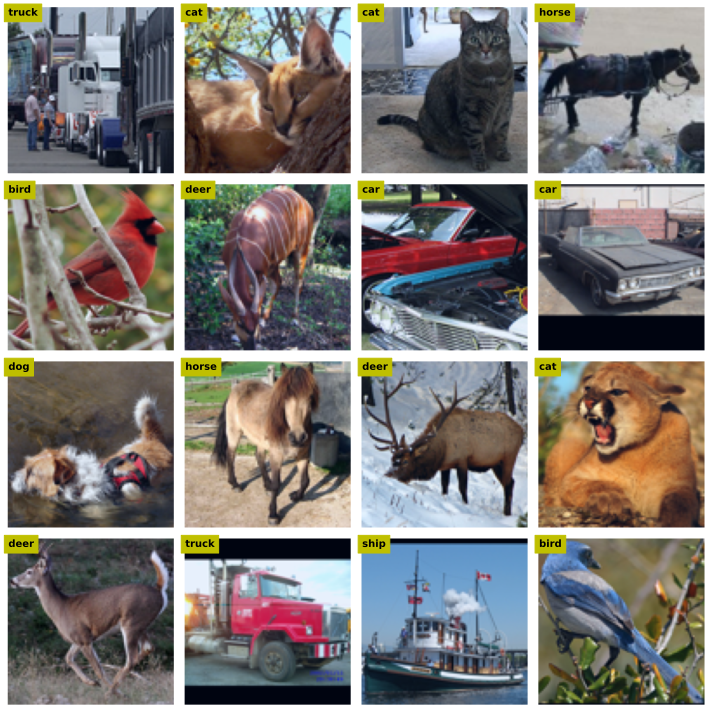

In [ ]:
#inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):


  #extract that image (need to transpose it back to 32x32x3)
  # Move the tensor to CPU and then convert it to numpy array
  pic = X.data[i].cpu().numpy().transpose((1, 2, 0))
  pic = pic-np.min(pic) #undo normalisation
  pic = pic/np.max(pic)

  # and it's labels
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top', fontweight = 'bold', color='k', backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

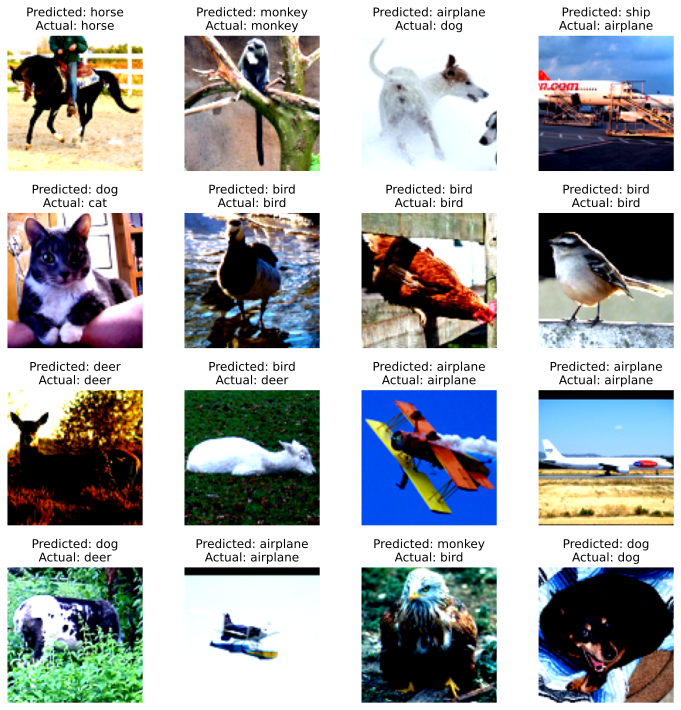

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Get some sample images and their labels from the test set
images, labels = next(iter(test_loader))

# Move images to device
images = images.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images with their predicted labels
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    image = images[i].cpu().numpy().transpose((1, 2, 0))
    image = 0.5 * image + 0.5  # Unnormalize the image
    ax.imshow(image)
    ax.set_title(f"Predicted: {trainset.classes[predicted[i].item()]}\nActual: {trainset.classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print(labels)

tensor([6, 7, 5, 0, 3, 1, 1, 1, 4, 4, 0, 0, 4, 0, 1, 5, 4, 9, 0, 6, 5, 3, 1, 3,
        2, 6, 5, 5, 2, 7, 1, 6, 3, 7, 9, 2, 4, 7, 9, 5, 1, 9, 0, 6, 4, 9, 1, 1,
        3, 2, 5, 4, 0, 0, 9, 8, 6, 7, 2, 0, 0, 1, 1, 7, 9, 6, 1, 8, 0, 4, 2, 1,
        7, 1, 2, 7, 5, 3, 5, 7, 3, 0, 9, 3, 0, 1, 8, 0, 2, 5, 4, 1, 3, 6, 5, 1,
        7, 5, 8, 5, 8, 3, 0, 2, 8, 7, 1, 2, 3, 4, 3, 2, 8, 1, 9, 0, 1, 4, 8, 1,
        4, 1, 8, 5, 2, 7, 8, 3, 4, 3, 6, 9, 7, 1, 5, 3, 0, 1, 5, 7, 1, 7, 1, 4,
        4, 3, 3, 9, 6, 3, 3, 8, 7, 5, 0, 1, 7, 1, 2, 8, 6, 5, 5, 3, 3, 8, 9, 1,
        0, 6, 6, 4, 4, 4, 8, 2, 3, 3, 1, 2, 0, 5, 8, 7, 8, 3, 7, 2, 6, 9, 6, 9,
        2, 8, 8, 6, 8, 9, 1, 4, 2, 7, 8, 7, 3, 3, 4, 4, 2, 5, 9, 4, 8, 3, 4, 1,
        9, 3, 6, 1, 0, 0, 0, 4, 2, 1, 4, 3, 9, 8, 7, 2, 8, 1, 6, 1, 6, 8, 5, 9,
        8, 0, 8, 9, 0, 5, 1, 6, 0, 3, 0, 2, 9, 6, 7, 6])


In [ ]:
print(trainset.classes)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
